#Duas bases de dados Json e excel

*   Json( Base normal e highlights)
*  Excel (Base residencial x comercial Preço medio port tipo)

### A ideia desse projeto é trabalhar o tratamento, organização e estilização dos dataframes usando metodos estatisticos e metodos dos pandas

# Importando pacotes

In [1]:
import pandas as pd
import numpy as np

# Configurações do projeto

In [ ]:
pd.get_option("display.max_rows")                  #visualizando como está o default dessa configuração

In [ ]:
pd.get_option("display.max_columns")  

In [4]:
pd.set_option("display.max_rows", 1000)            #configurei o tamanho visual que eu quero que mostre os dados

In [5]:
pd.set_option("display.max_columns", 1000)

## Carregando os dados
---

In [ ]:
bairros = pd.read_excel(                                            
    io = "bairros.xlsx",
        sheet_name="Preço médio por tipo",
        usecols="C:E",
        header = 2,
        index_col=[0, 1],
        names=['bairros','tipo','valor_m2_bairro']
)
bairros

In [ ]:
dados_json= pd.read_json(                                            
    path_or_buf ='realestates.json',
    orient= 'columns'
)
dados_json

# TRANSFORMANDO E TRATANDO OS DADOS
---

In [ ]:
dados_json_normal = pd.json_normalize(data=dados_json.normal, sep='_', record_path=['listings'])          # Em Json tenho duas colunas (normal e highlights), aqui eu transformo esses dataset em listas
dados_json_normal

In [ ]:
dados_json_highlights = pd.json_normalize(data=dados_json.highlights, sep='_', record_path=['listings'])
dados_json_highlights

In [ ]:
json_normal = dados_json_normal.loc[0,'imovel_caracteristicas_propriedade']                         #identifiquei que os dados da serie são em str
json_normal                                                                                                    

In [ ]:
type(json_normal)

In [ ]:
Texto = dados_json_normal.loc[:, 'imovel_caracteristicas_propriedade']                           # aplico o metodo string para toda serie, possibilitando tratamento dos dados e transformação para lista
Texto

In [ ]:
Texto.str

In [14]:
columns = dados_json_normal .filter(like='imovel_caracteristicas')                               # trago todo tratamento da string filtrando tudo que tem nos dois dataset compativeis com (imovel_caracteristicas)

for column in columns: 
    dados_json_normal [column] = dados_json_normal [column].str[1:-1].str.replace("'","").str.split(",")
    dados_json_highlights[column] = dados_json_highlights[column].str[1:-1].str.replace("'","").str.split(",")

In [ ]:
dados_json_normal.columns == dados_json_highlights.columns                                           #Todas as colunas do dataset são iguais 

In [ ]:
dados_unificados = dados_json_normal.append(dados_json_highlights, ignore_index= True)             #unifiquei os dois dataframes ignorando os index de ambos 
dados_unificados

## Combinando *DataFrames* a partir de uma chave de ligação
---

A ideia nessa etapa é criar uma unificação dos dois dataframes (json e excel)

In [ ]:
bairros_amostra = dados_json_normal['imovel_endereco_bairro']               #trago a coluna do json (imovel_endereço_ bairro)
bairros_amostra

In [ ]:
bairros_todos = bairros.index.get_level_values('bairros')                 #trago bairros do excel excluindo seus index
bairros_todos

In [ ]:
type(bairros_amostra.unique())                                             

In [ ]:
bairros_todos = pd.Series(bairros_amostra.unique())                       #transformo o array numpy em uma series do pandas 
bairros_todos

In [ ]:
bairros_todos = pd.Series(bairros_todos.unique())                       
bairros_todos

In [ ]:
bairros_amostra.isin(bairros_todos)                                      #está ok todos os dados estão corretos 

# Combinando os Dataframes de Bairros e Json
---

In [ ]:
dados_json_normal[['imovel_endereco_bairro', 'imovel_tipos_propriedade']]

In [ ]:
dados_json_normal= pd.merge(
    left = dados_json_normal,
    right= bairros, 
    left_on =['imovel_endereco_bairro', 'imovel_tipos_propriedade'],
    right_index= True

)

dados_json_normal

## Criando as colunas `quartos`, `suites` e `banheiros`

In [ ]:
dados_json_normal['anuncio_descricao']                                                 #quero extrair os dados de string dentro dessa serie (extraindo o numero de banheiros que cada imovel tem)

In [26]:
configuracao= dados_json_normal['anuncio_descricao'].str.extractall('(\d+)')           #uso a função str extractall para extrair os numeros dessa series

In [ ]:
configuracao = configuracao.unstack().rename(columns={0: 'quartos', 1: 'suites', 2: 'banheiros'})    #transformo os index em colunas e renomeio os nomes 
configuracao

In [28]:
configuracao.columns                                                                             #observo que as minhas colunas estão com multindex e para fazer o match no meu dataframe preciso tirar um dos niveis do index

MultiIndex([('quartos',   'quartos'),
            ('quartos',    'suites'),
            ('quartos', 'banheiros')],
           names=[None, 'match'])

In [ ]:
configuracao = configuracao.droplevel(level=0, axis=1)                                           #retiro o nivel 0 do meu index
configuracao

In [ ]:
dados_json_normal = pd.merge(dados_json_normal, configuracao, left_index=True, right_index=True)   # faço match das configurações que eu queria e com meu dataframe
dados_json_normal

## Criando novas classificações

In [31]:
tipo_uso = {                                                                                        #reclassifiquei os nomes para identificar os dados dentro do meu dataframe        
    'Apartamento': 'Residencial',
    'Casa': 'Residencial',
    'Cobertura': 'Residencial',
    'Consultório': 'Comercial',
    'Imóvel Comercial': 'Comercial',
    'Loja': 'Comercial',
    'Sala Comercial': 'Comercial'
}

In [32]:
imovel_tipos_uso = dados_json_normal.imovel_tipos_propriedade.map(tipo_uso)                          #vou reclassificar as colunas do meu dataframe, mapeando o tipo de imovel para possibilitar analises individuais 

In [33]:
dados_json_normal.insert(loc=0, column='imovel_tipos_uso', value=imovel_tipos_uso)                   #aplico o insert para incluir essa coluna reclassifica dentro do meu dataframe

In [ ]:
dados_json_normal

In [35]:
valor_minimo =dados_json_normal['anuncio_valores_venda'].min()                                   #quero classificar as categorias dos imoveis (popular, padrao e alto padrao) a partir do valor do imovel

valor_maximo =dados_json_normal['anuncio_valores_venda'].max()

rotulos = ['Popular', 'Padrão', 'Alto Padrão']                                                                                        

In [36]:
classes = [valor_minimo, 400000, 2000000, valor_maximo]                                               #criei uma classe personalizada com o limite dos meus valores

In [ ]:
dados_json_normal['classe_valor'] = pd.cut(x=dados_json_normal['anuncio_valores_venda'], bins=classes, labels=rotulos, include_lowest=True)  #incluo dentro do dataframe a classe personalizada com os parametros
dados_json_normal

In [38]:
valor_m2 = lambda data: data['anuncio_valores_venda'] / data['imovel_area'] if data['imovel_area'] !=0 else 0     #aqui eu aplico um argumento com a função lambda para caso a área do imóvel for igual a 0, eu mantenho a informação do 0

In [39]:
dados_json_normal['valor_m2'] = dados_json_normal.apply(valor_m2, axis=1)                                       #aplico essas funções nos eixos que esta determinado

#Sumarizações estatísticas

*   Item da lista
*   Item da lista



Com essas ferramentas consigo começar a identificar os possíveis candidatos a outlier dos dados e posso identificar também a possibilidade de precisar fazer algum tipo de separação nos dados.


In [ ]:
dados_json_normal[['anuncio_valores_venda', 'anuncio_valores_condominio', 'anuncio_valores_iptu']].agg(['sum', 'mean', 'std'])  #vou passar uma lista com as str com os metodos estatisticos que eu quero calcular 

In [ ]:
agrupamento = dados_json_normal[['imovel_tipos_propriedade', 'valor_m2']].groupby(by='imovel_tipos_propriedade')   #vou fazer uma sumarização de categorias trazendo a media, soma, mediana dos imoveis 
agrupamento  

In [ ]:
 agrupamento.mean().round()                                                                                      #aqui é um objeto do tipo DataFrameGroupBy, em cima dele eu vou fazer os agrupamentos.

In [ ]:
agrupamento.agg(func=['min', 'mean', 'max', 'std'])                                                              #incluo também os metodos estatisticos para calcular esse agrupamento de tipos de imoveis

In [44]:
agrupamento = dados_json_normal[['imovel_tipos_propriedade','classe_valor', 'valor_m2']].groupby(by=['imovel_tipos_propriedade', 'classe_valor']) #eu faço o agrupamento algumas colunas para acrescenta no meu dataframe

In [ ]:
agrupamento.mean().round()                                                                                     #faço alguns testes para saber esse agrupamento aconteceu 

In [ ]:
agrupamento.agg(func=['min', 'mean', 'max', 'std'])                                                            #com agregate eu passo também os metodos estatisticos para esse agruapamento 

#Tabelas de frequência

Quero entender com os dados estão distribuidos segundo as variaveis que eu tenho no DataFrame

In [ ]:
dados_json_normal.value_counts(subset='imovel_tipos_propriedade')  #contagem de quantos tipos de propriedade, quantos apartamentos eu tenho no meu dataset, quantas casas, quantas coberturas, todas as informações

In [ ]:
dados_json_normal.value_counts(subset='imovel_tipos_propriedade', normalize=True)  #aqui eu trago essa informação em percentual

In [ ]:
dados_json_normal.value_counts(subset=['imovel_tipos_uso', 'classe_valor'],normalize=True).to_frame(name= 'Percentual') * 100    #aqui eu incluo dentro de um dataframe para ficar melhor a visualização

## Mudando o formato de um *DataFrame*

Modelei os dados para uma melhor visualizacao, formatei os metodos estatisticos que estavam em colunas  para linhas e coloquei a classe de imoveis em colunas, também transformando meus indices em colunas no dataframe

In [ ]:
agrupamento = dados_json_normal[['imovel_tipos_propriedade','classe_valor', 'valor_m2']].groupby(by=['imovel_tipos_propriedade', 'classe_valor'])
agrupamento

In [ ]:
tabela_estatisticas = agrupamento.agg(func=['min', 'mean', 'std']).round(2)
tabela_estatisticas

In [ ]:
tabela_estatistica = tabela_estatisticas.stack(dropna=False)
tabela_estatistica

In [ ]:
tabela_estatistica.unstack(level= -2)

In [ ]:
tabela_estatisticas = tabela_estatisticas.droplevel(level=0, axis='columns')   
tabela_estatisticas 

In [ ]:
tabela_estatisticas.reset_index(inplace= True) 
tabela_estatisticas

In [ ]:
dados_json_normal.pivot_table(                                                             #Como meu dados já estão agregados ao meu Dataframe eu vou usar a função pivot_table() para construir a tabela dinamica
   values='valor_m2',
     index=['imovel_tipos_propriedade', 'classe_valor'],
     columns=['anuncio_tipos_listagem'],
     fill_value='-',
     margins=True,
     margins_name='Média Geral',
     dropna=False,
     aggfunc='mean'

)

# TABULAÇÕES E ESTILIZAÇÃO
---

Quero identificar todos os itens que existem nas colunas, eles estão em listas,para  fazer uma contagem das propriedades existentes, quais características ects 


In [ ]:
caracteristicas_propriedade= dados_json_normal['imovel_caracteristicas_propriedade']
caracteristicas_propriedade

In [99]:
caracteristicas_propriedade_itens = caracteristicas_propriedade.explode()

In [ ]:
caracteristicas_propriedade_itens.value_counts()

In [60]:
tabela_frequencias = pd.merge(
    left=caracteristicas_propriedade_itens.value_counts(),
    right=caracteristicas_propriedade_itens.value_counts(normalize=True),
    left_index=True,
    right_index=True
)

#Estilizando o DataFrame para futuras análises

In [ ]:
tabela_frequencias.rename(columns={                                             #renomenando algumas colunas do meu Dataframe 
        'imovel_caracteristicas_propriedade_x': 'Frequências',
        'imovel_caracteristicas_propriedade_y': 'Percentual'
}, inplace=True)

tabela_frequencias.rename_axis('características', inplace=True)

tabela_frequencias

In [ ]:
tabela_frequencias.style.format({'Percentual': '{:.2%}'})  #ajusto o percentual da minha serie com 2 numeros 

###Aplico um mapa de calor em barras no percentual para melhorar as visualizações


In [ ]:
tabela_frequencias.style.format({'Percentual': '{:.2%}'})\
                        .bar(subset='Percentual', vmin = 0.05, color = 'lightblue')\
                        .applymap(lambda x: f"color: {'red' if x >= 35 else 'black'}", subset = 'Frequências')\
                        .applymap(lambda x: f"font-weight: {'bold' if x >= 35 else 'normal'}", subset = 'Frequências')

#Estilização do Data set bairros

In [ ]:
bairros.unstack()

In [72]:
bairros_zona_sul = ['Ipanema', 'Botafogo', 'Catete', 'Copacabana', 'Lagoa', 'Flamengo', 'Gávea', 'Glória', 'Humaitá',
                    'Jardim Botânico', 'Laranjeiras', 'Leme', 'Urca', 'Vidigal', 'Cosme Velho', 'São Conrado', 'Rocinha',
                    'Leblon']

In [ ]:
tabela_zona_sul = bairros.unstack().query("index in " + str(bairros_zona_sul)).droplevel(level=0, axis=1)
tabela_zona_sul

###Seleciono apenas os dados da zona sul a aplico também o mapa de calor identificando os valores que estão positivos ou negativos no meu data set

In [ ]:
tabela_zona_sul.style \
               .format('R$ {:,.2f}') \
               .background_gradient(subset=['Apartamento'], cmap='Greens') \
               .background_gradient(subset=['Cobertura'], cmap='Blues')

# ANEXOS

In [68]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict

cmaps = OrderedDict()

In [69]:
cmaps['Perceptually Uniform Sequential'] = [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']

cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

cmaps['Sequential (2)'] = [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']

cmaps['Diverging'] = [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv']

cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

cmaps['Miscellaneous'] = [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral',
            'gist_ncar']

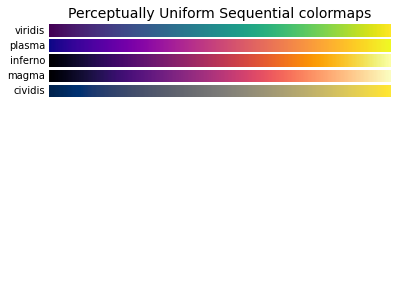

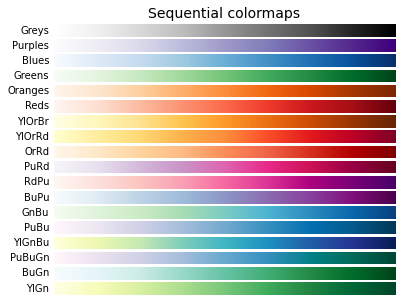

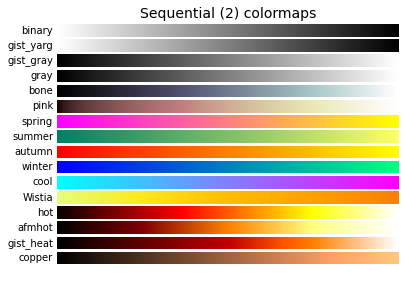

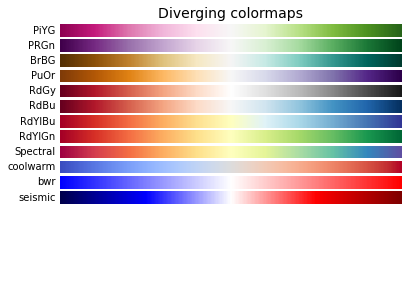

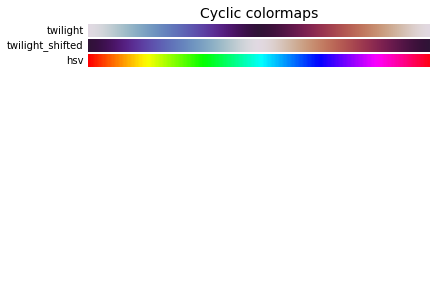

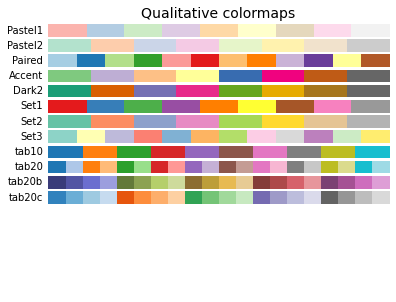

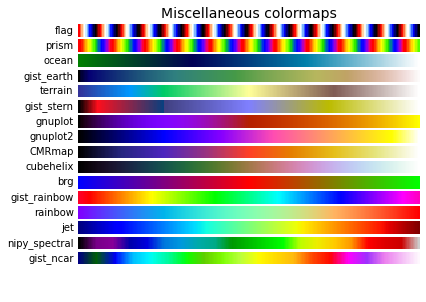

In [70]:
nrows = max(len(cmap_list) for cmap_category, cmap_list in cmaps.items())
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axes, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()


for cmap_category, cmap_list in cmaps.items():
    plot_color_gradients(cmap_category, cmap_list, nrows)

plt.show()